<a href="https://colab.research.google.com/github/Uz8351/MyPhython/blob/master/Transfer_Estilo_Aula_28_EN_4_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
80134624/80134624 [==============================] - 0s 0us/step
Iteración 100, Pérdida Total: 74661.65625
Iteración 200, Pérdida Total: 64191.65625
Iteración 300, Pérdida Total: 60087.28125
Iteración 400, Pérdida Total: 58197.53125
Iteración 500, Pérdida Total: 57170.80078125
Iteración 600, Pérdida Total: 56589.12890625
Iteración 700, Pérdida Total: 56214.33203125
Iteración 800, Pérdida Total: 55933.9453125
Iteración 900, Pérdida Total: 55712.59765625
Iteración 1000, Pérdida Total: 55524.0703125


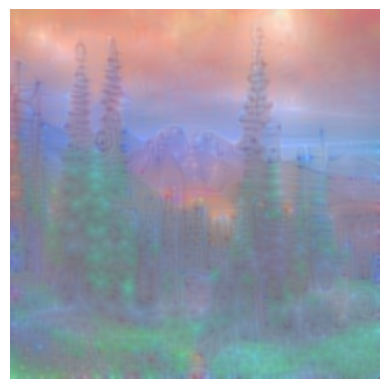

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Importar las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen original y la de estilo
original_path = "/content/drive/MyDrive/druida/paisaje.jpg"
style_path = "/content/drive/MyDrive/druida/picaso.jpg"

original_img = load_img(original_path, target_size=(224, 224))
style_img = load_img(style_path, target_size=(224, 224))

# Convertir las imágenes a matrices numpy
original_array = img_to_array(original_img)
style_array = img_to_array(style_img)

# Agregar una dimensión adicional para tener lotes de imágenes
original_array = np.expand_dims(original_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)

# Preprocesar las imágenes para que sean compatibles con el modelo VGG19
original_array = preprocess_input(original_array)
style_array = preprocess_input(style_array)

# Cargar el modelo VGG19 preentrenado en ImageNet (sin las capas densas al final)
base_model = VGG19(weights='imagenet', include_top=False)

# Definir las capas de estilo y contenido
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block4_conv2'

# Crear un modelo que devuelva las activaciones de las capas seleccionadas
style_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer).output for layer in style_layers])
content_model = Model(inputs=base_model.input, outputs=base_model.get_layer(content_layer).output)

# Obtener las activaciones de las capas de estilo y contenido para las imágenes de entrada
style_target = style_model(style_array)
content_target = content_model(original_array)

# Definir la imagen de salida como una variable TensorFlow
generated_img = tf.Variable(original_array)

# Función de pérdida de estilo
def style_loss(style, generated):
    return tf.reduce_mean(tf.square(style - generated))

# Función de pérdida de contenido
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# Función de pérdida total
def total_variation_loss(x):
    a = tf.square(x[:, : -1, : -1, :] - x[:, 1:, : -1, :])
    b = tf.square(x[:, : -1, : -1, :] - x[:, : -1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Parámetros de ponderación para las pérdidas
style_weight = 1e-2
content_weight = 1e-1
total_variation_weight = 1e-3

# Optimizador Adam
optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

# Número de iteraciones de optimización
iterations = 1000

# Bucle de optimización
for i in range(1, iterations + 1):
    with tf.GradientTape() as tape:
        # Obtener las activaciones de las capas de estilo y contenido para la imagen generada
        generated_target = content_model(generated_img)
        generated_style = style_model(generated_img)

        # Calcular las pérdidas de estilo, contenido y variación total
        loss_style = sum(style_loss(style, generated) for style, generated in zip(style_target, generated_style))
        loss_content = content_loss(content_target, generated_target)
        loss_variation = total_variation_loss(generated_img)

        # Calcular la pérdida total
        total_loss = style_weight * loss_style + content_weight * loss_content + total_variation_weight * loss_variation

    # Calcular los gradientes con respecto a la imagen generada
    gradients = tape.gradient(total_loss, generated_img)

    # Aplicar los gradientes al optimizador para actualizar la imagen generada
    optimizer.apply_gradients([(gradients, generated_img)])

    # Clip de valores de píxeles para mantenerlos en el rango [0, 255]
    generated_img.assign(tf.clip_by_value(generated_img, clip_value_min=0.0, clip_value_max=255.0))

    # Imprimir la pérdida cada 100 iteraciones
    if i % 100 == 0:
        print(f"Iteración {i}, Pérdida Total: {total_loss.numpy()}")

# Convertir la imagen generada de vuelta a un array de numpy
generated_img_array = np.array(generated_img.read_value())

# Deshacer el preprocesamiento de la imagen generada
generated_img_array = np.squeeze(generated_img_array, axis=0)
generated_img_array[:, :, 0] += 103.939
generated_img_array[:, :, 1] += 116.779
generated_img_array[:, :, 2] += 123.68
generated_img_array = np.clip(generated_img_array, 0, 255).astype('uint8')

# Visualizar la imagen generada
plt.imshow(generated_img_array)
plt.axis('off')
plt.show()
